# Thomson Scattering: Spectral Density

[thomson]: ../../diagnostics/thomson.rst
[spectral-density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#spectral-density
[sheffield]: https://www.sciencedirect.com/book/9780123748775/plasma-scattering-of-electromagnetic-radiation

The [thomson.spectral_density][spectral-density] function calculates the [spectral density function S(k,w)][sheffield], which is one of several terms that determine the scattered power spectrum for the Thomson scattering of a probe laser beam by a plasma. In particular, this function calculates $S(k,w)$ for the case of a plasma consisting of one or more ion species and electron populations under the assumption that all of the ion species and the electron fluid have Maxwellian velocity distribution functions and that the combined plasma is quasi-neutral. In this regime, the spectral density is given by the equation:

\begin{equation}
S(k,\omega) = \sum_e \frac{2\pi}{k} \bigg |1 - \frac{\chi_e}{\epsilon} \bigg |^2 f_{e0,e}\bigg ( \frac{\omega}{k} \bigg ) + \sum_i \frac{2\pi Z_i}{k} \bigg | \frac{\chi_e}{\epsilon} \bigg |^2 f_{i0, i} \bigg ( \frac{\omega}{k} \bigg )
\end{equation}

where $\chi_e$ is the electron component susceptibility of the plasma and $\epsilon = 1 + \sum_e \chi_e + \sum_i \chi_i$ is the total plasma dielectric function (with $\chi_i$ being the ion component of the susceptibility), $Z_i$ is the charge of each ion, $k$ is the scattering wavenumber, $\omega$ is the scattering frequency, and the functions $f_{e0,e}$ and $f_{i0,i}$ are the Maxwellian velocity distributions for the electrons and ion species respectively.

Thomson scattering can be either non-collective (the scattered spectrum is a linear sum of the light scattered by individual particles) or collective (the scattered spectrum is dominated by scattering off of collective plasma waves). The [thomson.spectral_density][spectral-density] function can be used in both cases. These regimes are delineated by the dimensionless constant $\alpha$:

\begin{equation}
\alpha = \frac{1}{k \lambda_{De}}
\end{equation}

where $\lambda_{De}$ is the Debye length. $\alpha > 1$ corresponds to collective scattering, while $\alpha < 1$ corresponds to non-collective scattering. Depending on which of these regimes applies, fitting the scattered spectrum can provide the electron (and sometimes ion) density and temperature. Doppler shifting of the spectrum can also provide a measurement of the drift velocity of each plasma species.

For a detailed explanation of the underlying physics (and derivations of these expressions), see ["Plasma Scattering of Electromagnetic Radiation" by Sheffield et al.][sheffield]

In [1]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from plasmapy.diagnostics import thomson

Construct parameters that define the Thomson diagnostic setup, the probing beam and scattering collection.  These parameters will be used for all examples.

In [2]:
# The probe wavelength can in theory be anything, but in practice integer frequency multiples of the Nd:YAG wavelength
# 1064 nm are used (532 corresponds to a frequency-doubled probe beam from such a laser).
probe_wavelength = 532 * u.nm

# Array of wavelengths over which to calcualte the spectral distribution
wavelengths = (
    np.arange(probe_wavelength.value - 60, probe_wavelength.value + 60, 0.01) * u.nm
)

# The scattering geometry is defined by unit vectors for the orientation of the probe laser beam (probe_n) and
# the path from the scattering volume (where the measurement is made) to the detector (scatter_n).
# These can be setup for any experimental geometry.
probe_vec = np.array([1, 0, 0])
scattering_angle = np.deg2rad(63)
scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])

In order to calcluate the scattered spectrum, we must also include some information about the plasma. For this plot we'll allow the ``fract``, ``ion_species``, ``fluid_vel``, and ``ion_vel`` keywords to keep their default values, describing a single-species H+ plasma at rest in the laboratory frame. 

Text(0.5, 1.0, 'Thomson Scattering Spectral Density')

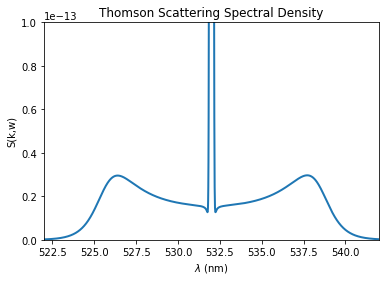

In [3]:
ne = 2e17 * u.cm ** -3
Te = 12 * u.eV
Ti = 10 * u.eV

alpha, Skw = thomson.spectral_density(
    wavelengths,
    probe_wavelength,
    ne,
    Te,
    Ti,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

fig, ax = plt.subplots()
ax.plot(wavelengths, Skw, lw=2)
ax.set_xlim(probe_wavelength.value - 10, probe_wavelength.value + 10)
ax.set_ylim(0, 1e-13)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("S(k,w)")
ax.set_title("Thomson Scattering Spectral Density")

### Example Cases in Different Scattering Regimes

We will now consider several example cases in different scattering regimes. In order to facilitate this, we'll set up each example as a dictionary of plasma parameters:

A single-species, stationary hydrogen plasma with a density and temperature that results in a scattering spectrum dominated by scattering off of single electrons.

In [4]:
non_collective = {
    "name": "Non-Collective Regime",
    "n": 5e15 * u.cm ** -3,
    "Te": 40 * u.eV,
    "Ti": np.array([10]) * u.eV,
    "ion_species": ["H+"],
    "electron_vel": np.array([[0, 0, 0]]) * u.km / u.s,
    "ion_vel": np.array([[0, 0, 0]]) * u.km / u.s,
}

A single-species, stationary hydrogen plasma with a density and temperature that result in weakly collective scattering (scattering paramter $\alpha$ approaching 1)

In [5]:
weakly_collective = {
    "name": "Weakly Collective Regime",
    "n": 2e17 * u.cm ** -3,
    "Te": 20 * u.eV,
    "Ti": 10 * u.eV,
    "ion_species": ["H+"],
    "electron_vel": np.array([[0, 0, 0]]) * u.km / u.s,
    "ion_vel": np.array([[0, 0, 0]]) * u.km / u.s,
}

A single-species, stationary hydrogen plasma with a density and temperature that result in a spectrum dominated by multi-particle scattering, including scattering off of ions.

In [6]:
collective = {
    "name": "Collective Regime",
    "n": 5e17 * u.cm ** -3,
    "Te": 10 * u.eV,
    "Ti": 4 * u.eV,
    "ion_species": ["H+"],
    "electron_vel": np.array([[0, 0, 0]]) * u.km / u.s,
    "ion_vel": np.array([[0, 0, 0]]) * u.km / u.s,
}

A case identical to the collective example above, except that now the electron fluid has a substantial drift velocity parallel to the probe laser and the ions have a drift (relative to the electrons) at an angle.

In [7]:
drifts = {
    "name": "Drift Velocities",
    "n": 5e17 * u.cm ** -3,
    "Te": 10 * u.eV,
    "Ti": 10 * u.eV,
    "ion_species": ["H+"],
    "electron_vel": np.array([[700, 0, 0]]) * u.km / u.s,
    "ion_vel": np.array([[-600, -100, 0]]) * u.km / u.s,
}

A case identical to the collective example, except that now the plasma consists 25% He+1 and 75% C+5, and two electron populations exist with different temperatures.

In [8]:
two_species = {
    "name": "Two Ion and Electron Components",
    "n": 5e17 * u.cm ** -3,
    "Te": np.array([50, 10]) * u.eV,
    "Ti": np.array([10, 50]) * u.eV,
    "efract": np.array([0.5, 0.5]),
    "ifract": np.array([0.25, 0.75]),
    "ion_species": ["He-4 1+", "C-12 5+"],
    "electron_vel": np.array([[0, 0, 0], [0, 0, 0]]) * u.km / u.s,
    "ion_vel": np.array([[0, 0, 0], [0, 0, 0]]) * u.km / u.s,
}

In [9]:
examples = [non_collective, weakly_collective, collective, drifts, two_species]

For each example, plot the the spectral distribution function over a large range to show the broad electron scattering feature (top row) and a narrow range around the probe wavelength to show the ion scattering feature (bottom row)

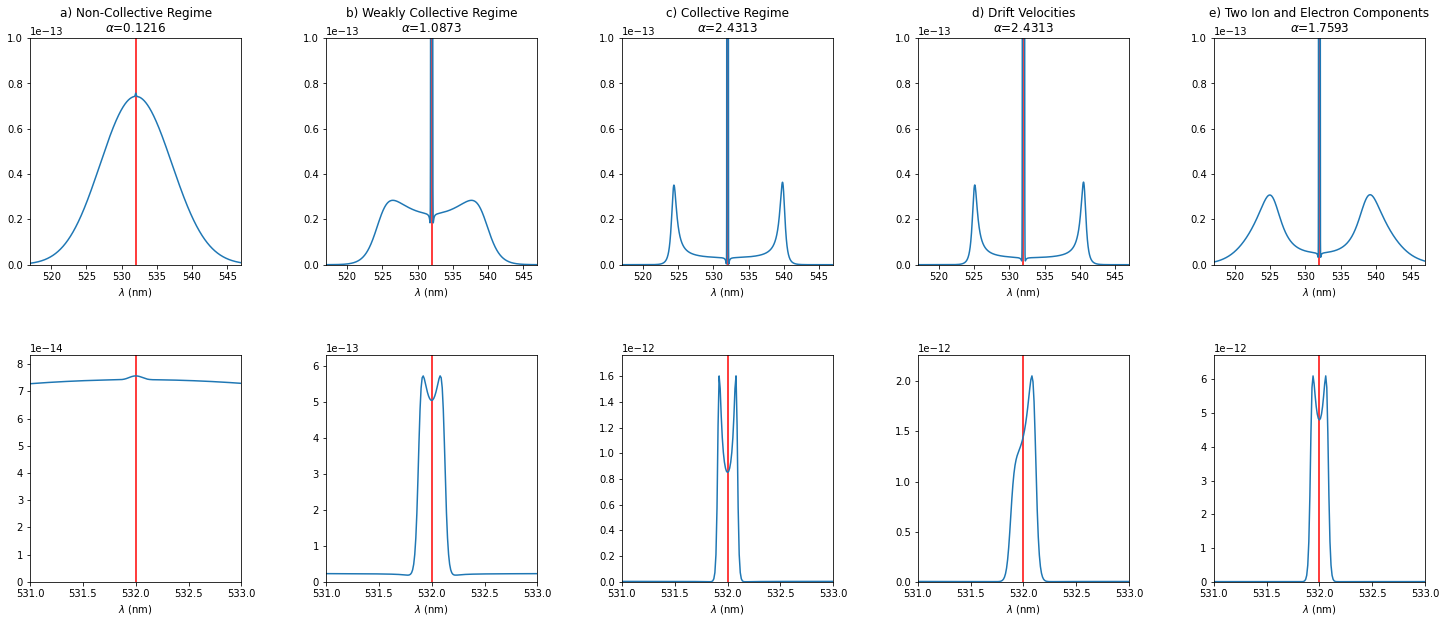

In [10]:
fig, ax = plt.subplots(ncols=len(examples), nrows=2, figsize=[25, 10])
fig.subplots_adjust(wspace=0.4, hspace=0.4)

lbls = "abcdefg"

for i, x in enumerate(examples):

    alpha, Skw = thomson.spectral_density(
        wavelengths,
        probe_wavelength,
        x["n"],
        x["Te"],
        x["Ti"],
        ifract=x.get("ifract"),
        efract=x.get("efract"),
        ion_species=x["ion_species"],
        electron_vel=x["electron_vel"],
        probe_vec=probe_vec,
        scatter_vec=scatter_vec,
    )

    ax[0][i].axvline(x=probe_wavelength.value, color="red")  # Mark the probe wavelength
    ax[0][i].plot(wavelengths, Skw)
    ax[0][i].set_xlim(probe_wavelength.value - 15, probe_wavelength.value + 15)
    ax[0][i].set_ylim(0, 1e-13)
    ax[0][i].set_xlabel("$\lambda$ (nm)")

    ax[0][i].set_title(lbls[i] + ") " + x["name"] + "\n$\\alpha$={:.4f}".format(alpha))

    ax[1][i].axvline(x=probe_wavelength.value, color="red")  # Mark the probe wavelength
    ax[1][i].plot(wavelengths, Skw)
    ax[1][i].set_xlim(probe_wavelength.value - 1, probe_wavelength.value + 1)
    ax[1][i].set_ylim(0, 1.1 * np.max(Skw.value))
    ax[1][i].set_xlabel("$\lambda$ (nm)")

Plots of the spectral density function (Skw) which determines the amount of light scattered into different wavelengths.

a. In the non-collective regime only the electron feature is visible.

b. In the weakly collective regime (alpha approaches 1) an ion feature starts to appear and the electron feature is distorted

c. In the collective regime both features split into two peaks, corresponding to scattering off of forward and backwards propagating plasma oscillations. 

d. The introduction of drift velocities introduces several Doppler shifts in the calculations, resulting in a shifted spectrum.

e. Including multiple ion and electron populations modifies the ion and electron features respectively.
